# Download dataset


In [1]:
# connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

# move to selected directory
%cd /content/drive/MyDrive/AML\ EX

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AML EX


In [ ]:
# setup kaggle credentials
import os
os.environ['KAGGLE_USERNAME'] = 'qingchengyu001'
os.environ['KAGGLE_KEY'] = '2e305b7c5be2de80581dd9cf4779b483'

# download kaggle dataset
! kaggle competitions download -c 'ieee-fraud-detection'

User cancelled operation
Exception ignored in atexit callback: <function _exit_function at 0x7fc221950c10>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 334, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 702, in _terminate_pool
    change_notifier.put(None)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 377, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", l

In [ ]:
# unzip downloaded dataset
! unzip ieee-fraud-detection.zip

Archive:  ieee-fraud-detection.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Cleaning

In [2]:
# import pandas and configure
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# load provided datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# combine datasets as needed
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# the dataset are sparse, only consider the features with less than 30% missing 
#   data, drop the columns have higher than 70% missing values
valid_cols = pd.DataFrame(train.isnull().sum()/len(train)*100 < 30)
valid_cols = valid_cols[valid_cols[0] == True]
train = train[list(valid_cols.index)]

In [4]:
import numpy as np

# seperate categorical variables, some categorical variables are stored as 
#   numerical values, for further procresses, convert to category data type
train = train.astype({'ProductCD': 'category',
                   'card1': 'category','card2': 'category','card3': 'category','card4': 'category','card5': 'category','card6': 'category',
                   'addr1': 'category','addr2': 'category',
                   'P_emaildomain': 'category',
                   'M6': 'category'})

# fill missing values in numerical columns with median values
num_cols = train.select_dtypes(include=np.number).columns.tolist()
for column in num_cols:
    train[column].fillna(train[column].median(), inplace=True)

In [5]:
from sklearn.model_selection import train_test_split

# seperate X and Y and split to development dataset and test dataset
train_X = train.drop(columns=['isFraud'])
train_Y = train['isFraud']
X_dev, X_test, y_dev, y_test = train_test_split(train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=42)

In [6]:
# drop high correlated (>0.9) features
corr_matrix = X_dev.corr().abs()

# create a mask for highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.9)]
X_dev = X_dev.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

<ipython-input-6-f57138035e0b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X_dev.corr().abs()


In [7]:
! pip install category_encoders
import category_encoders as ce
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# one-hot encoding for category features, StandardScaler for numerical feature, 
#   Taget encoding for  high cardinality categorical features
num_cols = X_dev.select_dtypes(include=np.number).columns.drop(['TransactionID']).tolist()
te_cols = ['TransactionID','card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']
cat_cols = X_dev.select_dtypes(exclude=np.number).columns.drop(['card1', 'card2', 'addr1', 'card5', 'card3', 'addr2', 'P_emaildomain']).tolist()
ohe_features = cat_cols
num_features = num_cols
te_features = te_cols

preprocess = make_column_transformer((StandardScaler(), num_features), (OneHotEncoder(handle_unknown='ignore'), ohe_features), (ce.TargetEncoder(return_df=True), te_features))
preprocess.fit(X_dev, y_dev)
X_dev = preprocess.transform(X_dev)
X_test = preprocess.transform(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(random_state=42)
X_dev, y_dev = smote.fit_resample(X_dev, y_dev)

# Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

# fit the decision tree on the development data until all the leaves ar
dtc = DecisionTreeClassifier(random_state=42) 
dtc.fit(X_dev, y_dev)

DecisionTreeClassifier(random_state=42)

In [10]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score

# use the model to predict for the train and test sets
y_test_pred = dtc.predict(X_test)

# calculate accuracy, precision, recall and F-1 on the test set
f1_test = f1_score(y_test, y_test_pred) 
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

# calculate the AUC ROC scores
auc_roc_test = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1])
auc_pr_test = average_precision_score(y_test, dtc.predict_proba(X_test)[:, 1] > 0.5)

print("\nTest Set")
print(f"Accuracy: {acc_test}")
print(f"Precision: {prec_test}")
print(f"Recall: {recall_test}")
print(f"F-1: {f1_test}")
print(f"AUC_ROC: {auc_roc_test}")
print(f"AUC_PR: {auc_pr_test}")


Test Set
Accuracy: 0.9651928743184204
Precision: 0.5023344651952462
Recall: 0.5727074764093879
F-1: 0.5352176370830979
AUC_ROC: 0.7760663944889667
AUC_PR: 0.30264312030784674


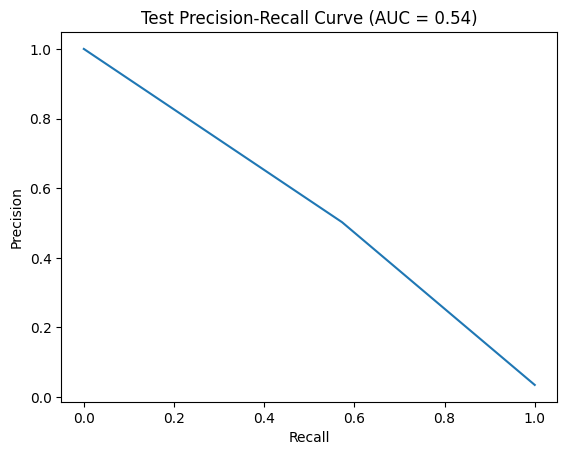

In [11]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

prc_p_test, prc_r_test, prc_thresholds_test = precision_recall_curve(y_test, dtc.predict_proba(X_test)[:, 1])
auc_pr = auc(prc_r_test, prc_p_test)

plt.plot(prc_r_test, prc_p_test)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Test Precision-Recall Curve (AUC = {auc_pr:.2f})")
plt.show()

In [12]:
# list the top three features found using a decision tree model

feature_importances = dtc.feature_importances_

ohe_feature_names = preprocess.named_transformers_['onehotencoder'].get_feature_names_out().tolist()
te_feature_names = te_features.copy()
num_feature_names = num_features.copy()
feature_names = num_feature_names + ohe_feature_names + te_feature_names

# sort the features by importance score in descending order
sorted_idx = feature_importances.argsort()[::-1]

print("Top 3 features:")
for i in range(3):
    print(f"{i+1}) {feature_names[sorted_idx[i]]}")

Top 3 features:
1) card1
2) V95
3) C1


# K-Fold Cross Validation on Decision Tree


In [15]:
! pip install optuna 
from sklearn.model_selection import cross_val_score, StratifiedKFold
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
# create the objective function used by optuna for optimaization
def dt_objective(trial):
    # define hyperparameters being optimized
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 3, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    # train the decision tree with optimized hyperparameters and 5-fold CV
    dtc2 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = cross_val_score(dtc2, X_dev, y_dev, cv=cv, scoring='roc_auc', n_jobs=-1)
    return np.mean(auc_scores)

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(dt_objective, n_trials=10)

# Get best hyperparameters and train final model
best_params = study.best_params
dtc3 = DecisionTreeClassifier(**best_params)
dtc3.fit(X_dev, y_dev)

[I 2023-04-30 20:02:16,957] A new study created in memory with name: no-name-16f46500-d0b7-42fd-903e-bd380821cdd5
[I 2023-04-30 20:05:31,706] Trial 0 finished with value: 0.9887758870039001 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9887758870039001.
[I 2023-04-30 20:08:55,180] Trial 1 finished with value: 0.9924538958613205 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9924538958613205.
[I 2023-04-30 20:12:15,122] Trial 2 finished with value: 0.9922993141061756 and parameters: {'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9924538958613205.
[I 2023-04-30 20:14:32,881] Trial 3 finished with value: 0.9774273853276995 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with val

Accuracy: 0.9644308598909472


In [19]:
# use the model to predict for the train and test sets
y_test_pred_opt = dtc3.predict(X_test)

# calculate accuracy, precision, recall and F-1 on the test set
f1_test_opt = f1_score(y_test, y_test_pred_opt) 
acc_test_opt = accuracy_score(y_test, y_test_pred_opt)
prec_test_opt = precision_score(y_test, y_test_pred_opt)
recall_test_opt = recall_score(y_test, y_test_pred_opt)

# calculate the AUC ROC scores
auc_roc_test_opt = roc_auc_score(y_test, dtc3.predict_proba(X_test)[:, 1])
auc_pr_test_opt = average_precision_score(y_test, dtc3.predict_proba(X_test)[:, 1] > 0.5)

print("\nTest Set")
print(f"Accuracy: {acc_test_opt}")
print(f"Precision: {prec_test_opt}")
print(f"Recall: {recall_test_opt}")
print(f"F-1: {f1_test_opt}")
print(f"AUC_ROC: {auc_roc_test_opt}")
print(f"AUC_PR: {auc_pr_test_opt}")
print("Best Hyperparameters: ", best_params)


Test Set
Accuracy: 0.9644308598909472
Precision: 0.4914271306101866
Recall: 0.4715702879264457
F-1: 0.4812939869119644
AUC_ROC: 0.8851131772490974
AUC_PR: 0.25023398358339477
Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}


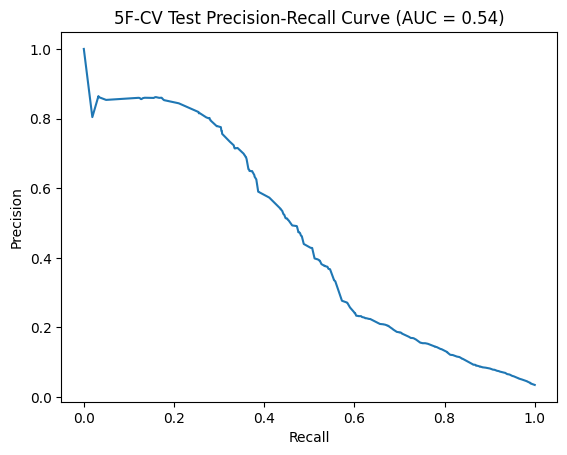

In [20]:
prc_p_test_opt, prc_r_test_opt, prc_thresholds_test_opt = precision_recall_curve(y_test, dtc3.predict_proba(X_test)[:, 1])
auc_pr_opt = auc(prc_r_test_opt, prc_p_test_opt)

plt.plot(prc_r_test_opt, prc_p_test_opt)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"5F-CV Test Precision-Recall Curve (AUC = {auc_pr:.2f})")
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.49      0.47      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.74      0.73      0.73    118108
weighted avg       0.96      0.96      0.96    118108



In [22]:
from sklearn.metrics import roc_curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dtc3.predict_proba(X_test)[:, 1], pos_label=1)
np.save('fpr_decisiontree.npy', fpr_dt)
np.save('tpr_decisiontree.npy', tpr_dt)